# GNN on OGB arXiv Citation Network

Using the OGB arXiv dataset (169k CS papers, 40 topics, 1.17M citations) to train GNN models for node classification and link prediction.

## Setup

In [ ]:
# Install required packages
!pip install torch torchvision
!pip install torch-geometric
!pip install ogb
!pip install matplotlib pandas numpy scikit-learn

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [8]:
# PyTorch 2.6+ compatibility
import torch.serialization
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage, EdgeStorage, NodeStorage

torch.serialization.add_safe_globals([
    DataEdgeAttr, DataTensorAttr, Data, 
    GlobalStorage, EdgeStorage, NodeStorage
])

In [9]:
from ogb.nodeproppred import PygNodePropPredDataset

# Load dataset
print("Loading OGB arXiv dataset...")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='data/')
data = dataset[0]

# Create masks
split_idx = dataset.get_idx_split()
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[split_idx['train']] = True
data.val_mask[split_idx['valid']] = True
data.test_mask[split_idx['test']] = True
data.y = data.y.view(-1)

print(f"\nDataset stats:")
print(f"Nodes: {data.num_nodes:,}")
print(f"Edges: {data.num_edges:,}")
print(f"Features: {data.num_features}")
print(f"Classes: {dataset.num_classes}")
print(f"Train: {data.train_mask.sum():,} | Val: {data.val_mask.sum():,} | Test: {data.test_mask.sum():,}")

Loading OGB arXiv dataset...

Dataset stats:
Nodes: 169,343
Edges: 1,166,243
Features: 128
Classes: 40
Train: 90,941 | Val: 29,799 | Test: 48,603


## Model Definitions

In [10]:
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.bn1(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = self.bn2(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

print("Models defined")

Models defined


## Training Function

In [11]:
def train_model(model, data, model_name, epochs=200, lr=0.01, weight_decay=5e-4, patience=40):
    model = model.to(device)
    data = data.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_acc': [], 'test_acc': []}
    best_val_acc = 0
    best_test_acc = 0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)
                pred = out.argmax(dim=1)
                
                val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
                test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
                
                history['train_loss'].append(loss.item())
                history['val_acc'].append(val_acc.item())
                history['test_acc'].append(test_acc.item())
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc.item()
                    best_test_acc = test_acc.item()
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
        
        scheduler.step()
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Loss={loss.item():.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")
        
        if patience_counter >= patience // 5:
            print(f"Early stop at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_model_state)
    
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
    
    print(f"{model_name}: Best val={best_val_acc:.4f}, test={best_test_acc:.4f}\n")
    return model, history, best_test_acc, pred

print("Training function ready")

Training function ready


## Node Classification

In [14]:
# Train GAT
print("Training GAT...")
gat = GAT(data.num_features, 128, dataset.num_classes)
gat, gat_hist, gat_test_acc, gat_pred = train_model(gat, data, "GAT", epochs=100, patience=20)


Training GAT...
Epoch  20: Loss=2.5883 | Val=0.4676 | Test=0.4277
Epoch  40: Loss=2.3738 | Val=0.5368 | Test=0.4887
Epoch  60: Loss=2.2970 | Val=0.5564 | Test=0.5085
Epoch  80: Loss=2.2711 | Val=0.5597 | Test=0.5083
Early stop at epoch 90
GAT: Best val=0.5604, test=0.5092



In [12]:
# Train GCN
print("Training GCN...")
gcn = GCN(data.num_features, 128, dataset.num_classes)
gcn, gcn_hist, gcn_test_acc, gcn_pred = train_model(gcn, data, "GCN", epochs=100, patience=20)


Training GCN...
Epoch  20: Loss=2.0148 | Val=0.5387 | Test=0.5050
Epoch  40: Loss=1.8964 | Val=0.5475 | Test=0.4927
Epoch  60: Loss=1.8504 | Val=0.5495 | Test=0.4875
Epoch  80: Loss=1.8372 | Val=0.5525 | Test=0.4909
Epoch 100: Loss=1.8391 | Val=0.5537 | Test=0.4906
GCN: Best val=0.5537, test=0.4906



In [13]:
# Train GraphSAGE
print("Training GraphSAGE...")
sage = GraphSAGE(data.num_features, 128, dataset.num_classes)
sage, sage_hist, sage_test_acc, sage_pred = train_model(sage, data, "GraphSAGE", epochs=100, patience=20)

Training GraphSAGE...
Epoch  20: Loss=1.8699 | Val=0.5030 | Test=0.4712
Epoch  40: Loss=1.7469 | Val=0.5544 | Test=0.4832
Epoch  60: Loss=1.7002 | Val=0.5638 | Test=0.4918
Epoch  80: Loss=1.6794 | Val=0.5738 | Test=0.5045
Epoch 100: Loss=1.6877 | Val=0.5755 | Test=0.5077
GraphSAGE: Best val=0.5755, test=0.5077



In [15]:
# Results
results = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test Accuracy': [gat_test_acc, gcn_test_acc, sage_test_acc]
})

print("\nNode Classification Results:")
print(results.to_string(index=False))
print()


Node Classification Results:
    Model  Test Accuracy
      GAT       0.509207
      GCN       0.490566
GraphSAGE       0.507664



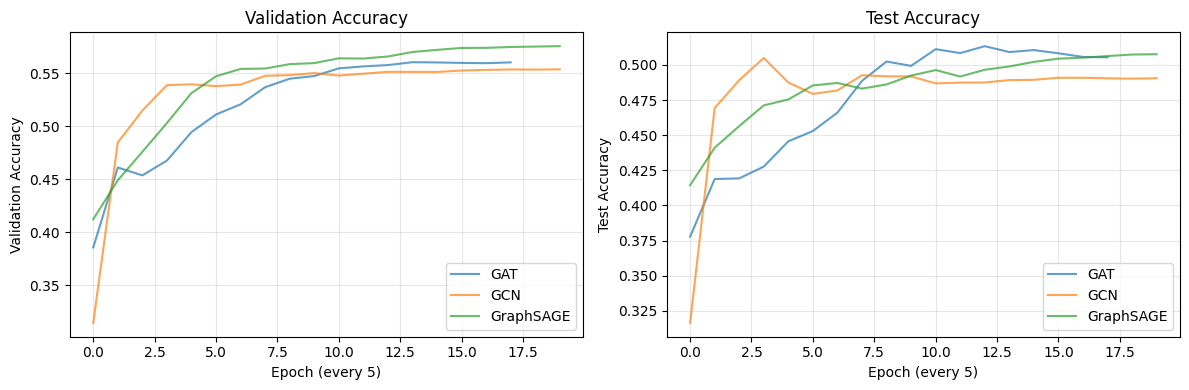

In [16]:
# Training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gat_hist['val_acc'], label='GAT', alpha=0.7)
plt.plot(gcn_hist['val_acc'], label='GCN', alpha=0.7)
plt.plot(sage_hist['val_acc'], label='GraphSAGE', alpha=0.7)
plt.xlabel('Epoch (every 5)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(gat_hist['test_acc'], label='GAT', alpha=0.7)
plt.plot(gcn_hist['test_acc'], label='GCN', alpha=0.7)
plt.plot(sage_hist['test_acc'], label='GraphSAGE', alpha=0.7)
plt.xlabel('Epoch (every 5)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ensemble Prediction

In [17]:
def ensemble_predict(models, data):
    data = data.to(device)
    predictions = []
    
    for model in models:
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            predictions.append(F.softmax(out, dim=1))
    
    ensemble_pred = torch.stack(predictions).mean(dim=0)
    return ensemble_pred.argmax(dim=1)

print("Ensemble prediction")

# Combine all models
all_models = [gat, gcn, sage]
ensemble_pred = ensemble_predict(all_models, data)

# Calculate accuracy
ensemble_test_acc = (ensemble_pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

print(f"\nEnsemble test accuracy: {ensemble_test_acc:.4f}")
print(f"Best individual: {max(gat_test_acc, gcn_test_acc, sage_test_acc):.4f}")
print(f"Improvement: +{(ensemble_test_acc - max(gat_test_acc, gcn_test_acc, sage_test_acc)):.4f}")

Ensemble prediction

Ensemble test accuracy: 0.5111
Best individual: 0.5092
Improvement: +0.0019


In [18]:
# Complete comparison
results_comparison = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE', 'Ensemble'],
    'Test Accuracy': [gat_test_acc, gcn_test_acc, sage_test_acc, ensemble_test_acc]
})

print("\nComplete results:")
print(results_comparison.to_string(index=False))
print()


Complete results:
    Model  Test Accuracy
      GAT       0.509207
      GCN       0.490566
GraphSAGE       0.507664
 Ensemble       0.511141



## Link Prediction

In [19]:
# Edge splits
num_edges = data.edge_index.shape[1]
perm = torch.randperm(num_edges)

num_val = int(0.1 * num_edges)
num_test = int(0.1 * num_edges)

train_edges = data.edge_index[:, perm[num_val + num_test:]]
val_pos = data.edge_index[:, perm[:num_val]]
test_pos = data.edge_index[:, perm[num_val:num_val + num_test]]

def sample_negative_edges(num_samples, existing_edges):
    edge_set = set(map(tuple, existing_edges.t().tolist()))
    neg_edges = []
    while len(neg_edges) < num_samples:
        src = torch.randint(0, data.num_nodes, (1,)).item()
        dst = torch.randint(0, data.num_nodes, (1,)).item()
        if src != dst and (src, dst) not in edge_set:
            neg_edges.append([src, dst])
    return torch.tensor(neg_edges, dtype=torch.long).t()

val_neg = sample_negative_edges(num_val, data.edge_index)
test_neg = sample_negative_edges(num_test, data.edge_index)

print(f"Edge splits:")
print(f"Train: {train_edges.shape[1]:,} | Val: {val_pos.shape[1]:,} | Test: {test_pos.shape[1]:,}")

Edge splits:
Train: 932,995 | Val: 116,624 | Test: 116,624


In [20]:
def train_link_prediction(model, data, train_edges, val_pos, val_neg, test_pos, test_neg, epochs=50):
    model = model.to(device)
    data_train = Data(x=data.x.to(device), edge_index=train_edges.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    best_val_auc = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        z = model(data_train.x, data_train.edge_index)
        
        num_samples = min(5000, train_edges.shape[1])
        pos_idx = torch.randperm(train_edges.shape[1])[:num_samples]
        pos_edges = train_edges[:, pos_idx].to(device)
        neg_edges = sample_negative_edges(num_samples, train_edges).to(device)
        
        pos_score = (z[pos_edges[0]] * z[pos_edges[1]]).sum(dim=1)
        neg_score = (z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1)
        
        loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean() - torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                z = model(data_train.x, data_train.edge_index)
                pos_score = (z[val_pos.to(device)[0]] * z[val_pos.to(device)[1]]).sum(dim=1)
                neg_score = (z[val_neg.to(device)[0]] * z[val_neg.to(device)[1]]).sum(dim=1)
                scores = torch.cat([pos_score, neg_score]).cpu().numpy()
                labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])
                val_auc = roc_auc_score(labels, scores)
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    best_model_state = model.state_dict().copy()
                print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Val AUC={val_auc:.4f}")
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Test
    model.eval()
    with torch.no_grad():
        z = model(data_train.x, data_train.edge_index)
        pos_score = (z[test_pos.to(device)[0]] * z[test_pos.to(device)[1]]).sum(dim=1)
        neg_score = (z[test_neg.to(device)[0]] * z[test_neg.to(device)[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])
        test_auc = roc_auc_score(labels, scores)
    
    print(f"Best val AUC={best_val_auc:.4f}, test AUC={test_auc:.4f}\n")
    return test_auc

In [22]:
# Train GAT
print("Training GAT...")
gat_link = GAT(data.num_features, 128, 64)
gat_link_auc = train_link_prediction(gat_link, data, train_edges, val_pos, val_neg, test_pos, test_neg)

Training GAT...
Epoch 10: Loss=9.4510, Val AUC=0.7766
Epoch 20: Loss=8.9344, Val AUC=0.5333
Epoch 30: Loss=9.0178, Val AUC=0.7673
Epoch 40: Loss=9.2373, Val AUC=0.7630
Epoch 50: Loss=8.7157, Val AUC=0.7562
Best val AUC=0.7766, test AUC=0.7549



In [23]:
# Train GCN
print("Training GCN...")
gcn_link = GCN(data.num_features, 128, 64)
gcn_link_auc = train_link_prediction(gcn_link, data, train_edges, val_pos, val_neg, test_pos, test_neg)

Training GCN...
Epoch 10: Loss=3.8210, Val AUC=0.8748
Epoch 20: Loss=1.3180, Val AUC=0.8726
Epoch 30: Loss=1.1056, Val AUC=0.9104
Epoch 40: Loss=1.0859, Val AUC=0.9209
Epoch 50: Loss=1.0207, Val AUC=0.9275
Best val AUC=0.9275, test AUC=0.9275



In [24]:
# Train GraphSAGE
print("Training GraphSAGE...")
sage_link = GraphSAGE(data.num_features, 128, 64)
sage_link_auc = train_link_prediction(sage_link, data, train_edges, val_pos, val_neg, test_pos, test_neg)

Training GraphSAGE...
Epoch 10: Loss=1.5202, Val AUC=0.7546
Epoch 20: Loss=1.3192, Val AUC=0.7867
Epoch 30: Loss=1.2412, Val AUC=0.8082
Epoch 40: Loss=1.2040, Val AUC=0.8479
Epoch 50: Loss=1.2154, Val AUC=0.8692
Best val AUC=0.8692, test AUC=0.8677



In [25]:
# Link prediction results
results_link = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test AUC': [gat_link_auc, gcn_link_auc, sage_link_auc]
})

print("\nLink Prediction Results:")
print(results_link.to_string(index=False))
print()


Link Prediction Results:
    Model  Test AUC
      GAT  0.754905
      GCN  0.927476
GraphSAGE  0.867695



## Save Models

In [26]:
# Save models
Path('saved_models').mkdir(exist_ok=True)

torch.save({
    'gat': gat.state_dict(),
    'gcn': gcn.state_dict(),
    'sage': sage.state_dict(),
    'gat_link': gat_link.state_dict(),
    'gcn_link': gcn_link.state_dict(),
    'sage_link': sage_link.state_dict(),
    'results': {
        'node_classification': results.to_dict(),
        'ensemble': ensemble_test_acc,
        'link_prediction': results_link.to_dict()
    }
}, 'saved_models/OGB_models.pt')

print("Models saved to saved_models/OGB_models.pt")

Models saved to saved_models/OGB_models.pt


In [27]:
# Summary
print("\nFinal Summary\n")

print("Node Classification:")
print(results.to_string(index=False))
print(f"\nEnsemble: {ensemble_test_acc:.4f}")

print("\nLink Prediction:")
print(results_link.to_string(index=False))

print("\nDone!")


Final Summary

Node Classification:
    Model  Test Accuracy
      GAT       0.509207
      GCN       0.490566
GraphSAGE       0.507664

Ensemble: 0.5111

Link Prediction:
    Model  Test AUC
      GAT  0.754905
      GCN  0.927476
GraphSAGE  0.867695

Done!
